In [336]:
from pyod.models.copod import COPOD
import os
import matplotlib.pyplot as plt
import seaborn
import pandas as pd
import numpy as np
import re
import pyod
import torch
import pyod.models.auto_encoder_torch as ae
import pyod.models.cblof as cblof
import pyod.models.knn as knn

# Potentially added at a later point, but need it install SUOD on Conda
# import pyod.models.suod as SUOD

In [355]:
def plot_results(data, anamoly_score, threshold, anamoly_pos, title, file_to_load):
    
    fig, (ax1, ax2) = plt.subplots(2)
    fig.suptitle(title)
    ax1.plot(total[0:threshold], color = 'gray')
    ax1.plot(total[threshold:], color = 'blue')
    ax1.set_ylabel('Value')
    ax1.axvline(threshold, label='threshold', color = 'black')
    ax1.axvline(anamoly_pos, label='predicted anamoly', color = 'red')
    ax2.plot(anamoly_score[0:threshold], color = 'gray')
    ax2.plot(anamoly_score[threshold:], color = 'blue')
    ax2.set_ylabel('Anamoly Score')
    ax2.axvline(threshold, label='threshold', color = 'black')
    ax2.axvline(anamoly_pos, label='predicted anamoly', color = 'red')
    plt.show()

In [338]:
# Define split data

def split_data(file_path, index):
    file_name = os.listdir(file_path)[index]
    test_data_start_pt = int(re.findall(
        r'[0-9]*.txt', file_name)[0].split('.')[0])
    total_data = pd.read_csv(os.path.join(file_path, os.listdir(file_path)[index]))
    train_data = total_data[0:test_data_start_pt]
    test_data = total_data[test_data_start_pt+1:len(total_data)]

    return train_data, test_data, total_data, test_data_start_pt

In [343]:
# Initialize all anamoly lists to be zero

# Filename
file_name_list = []

# Autoencoder
anamoly_pos_autoenc = []

# Cluster-based Local Outlier Factor
anamoly_pos_CBLOF = []

# K-Nearest Neighbors
anamoly_pos_KNN = []

# Copula-Based Outlier Detection
anamoly_pos_COPOD = []


# for k in range(len(os.listdir(file_path))-1):
for k in range(10):
    # define path to data directory
    file_path = os.path.join(os.getcwd(), 'KDD-Cup', 'data')
    file_name = os.listdir(file_path)[k+1]
    file_to_load = os.path.join(file_path, file_name)
    train, test, total, threshold = split_data(file_path, k+1)
    
    autoenc_pred, CBLOF_pred, KNN_pred, COPOD_pred = train_models()
    
    # Add value for each item to list
    file_name_list.append(file_name) 
    anamoly_pos_autoenc.append(autoenc_pred) 
    anamoly_pos_CBLOF.append(CBLOF_pred) 
    anamoly_pos_KNN.append(KNN_pred) 
    anamoly_pos_COPOD.append(COPOD_pred) 
    
    
# Create Data frame of predicted anamolies
predictions = pd.DataFrame({'File Name': file_name_list, 'AutoEncoder': anamoly_pos_autoenc, 'CBLOF':anamoly_pos_CBLOF, 'KNN': anamoly_pos_KNN, 'COPOD':anamoly_pos_COPOD} ) 
predictions

inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (batch_norm0): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (batch_norm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (batch_norm0): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (batch_norm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
  )
)
epoch 0: training

File Name  AutoEncoder  CBLOF    KNN  COPOD
0  001_UCR_Anomaly_35000.txt        71184  66888  71184  66888
1  002_UCR_Anomaly_35000.txt        67095  67095  67095  67095
2  003_UCR_Anomaly_35000.txt        71389  71389  67094  67094
3   004_UCR_Anomaly_2500.txt         5590   5590   5590   5590
4   005_UCR_Anomaly_4000.txt         6276   6253   6254   6253
5   006_UCR_Anomaly_4000.txt         6077   5101   6252   5101
6   007_UCR_Anomaly_4000.txt         5078   5078   5078   5078
7   008_UCR_Anomaly_4000.txt         4791   4791   4790   4791
8   009_UCR_Anomaly_4000.txt         5376   6253   6700   6253
9   010_UCR_Anomaly_4000.txt         4643   5101   5101   5101

In [325]:
def train_models():
    
    # Autoencoder
    anamoly_pos_autoenc, test_outlier_scores_autoenc = Detect_AE()

    # Cluster-based Local Outlier Factor
    anamoly_pos_CBLOF, test_outlier_scores_CBLOF = Detect_CBLOF()

    # K-Nearest Neighbors
    anamoly_pos_KNN, test_outlier_scores_KNN = Detect_KNN()

    # Copula-Based Outlier Detection
    anamoly_pos_COPOD, test_outlier_scores_COPOD = Detect_COPOD()
    
    return anamoly_pos_autoenc, anamoly_pos_CBLOF, anamoly_pos_KNN, anamoly_pos_COPOD
    

In [327]:
def Detect_AE():
    # Implement algorithm #1 (Autoencoding)
    # https://pyod.readthedocs.io/en/latest/pyod.models.html#pyod-models-auto-encoder-module

    # Define model (TBD hidden neuron details...)
    clf = ae.AutoEncoder(epochs = 1)

    # Fit model
    clf.fit(train)
    
    # Determine outlier scores for training data
    train_outlier_scores = clf.decision_scores_
    
    # Determine outlier scores for test data
    test_outlier_scores = clf.decision_function(total)
    test_outlier_scores = pd.Series(test_outlier_scores)
    anamoly_pos = test_outlier_scores[threshold:].idxmax()
    print("Predicted Anamoloy from Autoencoder algorithm is located at location: " + str(anamoly_pos))
    
    return anamoly_pos, test_outlier_scores

In [328]:
def Detect_CBLOF():
    # Implement algorithm #2 (CBLOF)
    outliers_fraction = 0.000000001

    # Define model (TBD hidden neuron details...)
    clf = cblof.CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=0)

    # Fit model
    clf.fit(train)

    # Determine outlier scores for training data
    train_outlier_scores = clf.decision_scores_

    # Determine outlier scores for test data
    test_outlier_scores = clf.decision_function(total)
    test_outlier_scores = pd.Series(test_outlier_scores)
    anamoly_pos = test_outlier_scores[threshold:].idxmax()
    print("Predicted Anamoloy from CBLOF algorithm is located at location: " + str(anamoly_pos))
    
    return anamoly_pos, test_outlier_scores

In [329]:
def Detect_KNN():
    # Implement algorithm #3 (K-Nearest Neighbors)
    outliers_fraction = 0.000000001

    # Define model (TBD hidden neuron details...)
    clf = knn.KNN(contamination=outliers_fraction)

    # Fit model
    clf.fit(train)

    # Determine outlier scores for training data
    train_outlier_scores = clf.decision_scores_

    # Determine outlier scores for test data
    test_outlier_scores = clf.decision_function(total)
    test_outlier_scores = pd.Series(test_outlier_scores)
    anamoly_pos = test_outlier_scores[threshold:].idxmax()
    print("Predicted anamoloy from KNN algorithm is located at location: " + str(anamoly_pos))
    
    return anamoly_pos, test_outlier_scores

In [330]:
def Detect_COPOD():    
    # Implement algorithm #4 (COPOD)

    ##### COPOD Algorithm
    clf = COPOD()
    clf.fit(train)

    # Fit model
    clf.fit(train)

    # Determine outlier scores for training data
    train_outlier_scores = clf.decision_scores_

    # Determine outlier scores for test data
    test_outlier_scores = clf.decision_function(total)
    test_outlier_scores = pd.Series(test_outlier_scores)
    anamoly_pos = test_outlier_scores[threshold:].idxmax()
    print("Predicted anamoloy from COPOD algorithm  is located at location: " + str(anamoly_pos))
    
    return anamoly_pos, test_outlier_scores

In [350]:
#### Below for development purposes ####
print(file_name)

# Autoencoder
anamoly_pos_autoenc, test_outlier_scores_autoenc = Detect_AE()

# Cluster-based Local Outlier Factor
anamoly_pos_CBLOF, test_outlier_scores_CBLOF = Detect_CBLOF()

# K-Nearest Neighbors
anamoly_pos_KNN, test_outlier_scores_KNN = Detect_KNN()

# Copula-Based Outlier Detection
anamoly_pos_COPOD, test_outlier_scores_COPOD = Detect_COPOD()

010_UCR_Anomaly_4000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (batch_norm0): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (batch_norm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (batch_norm0): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (batch_norm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False

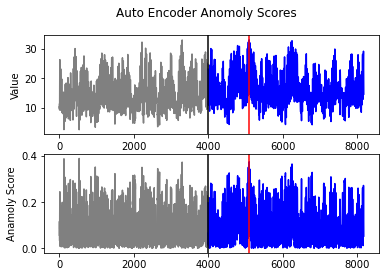

In [356]:
# Plot results
plot_results(total, test_outlier_scores_autoenc, threshold, anamoly_pos_autoenc, "Auto Encoder Anomoly Scores", file_to_load)

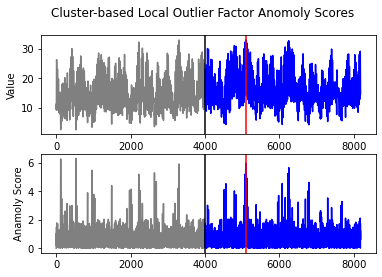

In [357]:
# Plot results
plot_results(total, test_outlier_scores_CBLOF, threshold, anamoly_pos_CBLOF, "Cluster-based Local Outlier Factor Anomoly Scores", file_to_load)

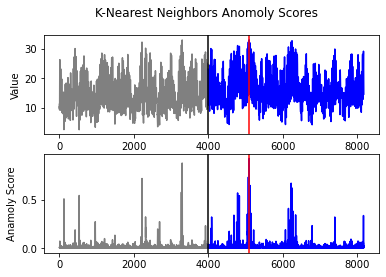

In [358]:
# Plot results
plot_results(total, test_outlier_scores_KNN, threshold, anamoly_pos_KNN, "K-Nearest Neighbors Anomoly Scores", file_to_load)

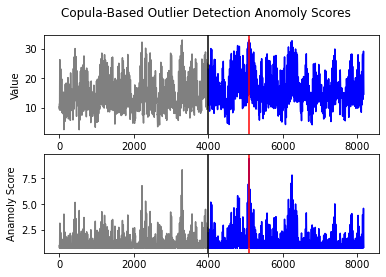

In [359]:
# Plot
plot_results(total, test_outlier_scores_COPOD, threshold, anamoly_pos_COPOD, "Copula-Based Outlier Detection Anomoly Scores", file_to_load)

In [360]:
total

1.2148905e+01
0            11.146226
1            10.104918
2             9.693486
3            10.462973
4            10.518648
...                ...
8178         20.938801
8179         18.650134
8180         17.076300
8181         15.486738
8182         14.585764

[8183 rows x 1 columns]